In [1]:
from datetime import datetime

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

# Misc
seed = 42
epochs = 150
lr = 1e-2
bs_trn = 1024

# Agent
init_money = 10000
sell_rate = 0.015
fee = 0.001
thres = 10

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_price(file_name, data):
    """Plot financial price overtime."""
    sns.set_style("darkgrid")
    plt.figure(figsize=(15, 9))
    plt.plot(data[["Close"]])
    plt.xticks(
        range(0, data.shape[0], 1000), data["Open time"].loc[::1000], rotation=45
    )
    plt.title("Price", fontsize=18, fontweight="bold")
    plt.xlabel("Date", fontsize=18)
    plt.ylabel("Close Price (USD)", fontsize=18)
#     plt.savefig(f"images/{file_name}_data.png")


def plot_prediction(df, ticker):
    """plot prediction results."""
    plt.figure(figsize=(30, 7))
    plt.title("Predictive model " + str(ticker))
    plt.plot(df["Open time"], df["Close"], label="Close", alpha=0.2)

    buy_df = df["Buy"] * df["Close"]

    plt.scatter(
        df["Open time"].loc[~(df.Buy == 0)],
        buy_df.loc[~(buy_df == 0)],
        label="Buy",
        marker="^",
        color="magenta",
        alpha=0.15,
    )

    sell_df = df["Sell"] * df["Close"]

    plt.scatter(
        df["Open time"].loc[~(df.Sell == 0)],
        sell_df.loc[~(sell_df == 0)],
        label="Sell",
        marker="*",
        color="blue",
        alpha=0.15,
    )

    plt.legend()
#     plt.savefig(f"images/{ticker}_prediction.png")

In [3]:
import os
from datetime import datetime

import numpy as np
import pandas as pd
import pandas_ta as ta
import torch
from torch.utils.data import DataLoader, Dataset

predictors_list = [
    "aboveSAR",
    "aboveUpperBB",
    "belowLowerBB",
    "normRSI",
    "oversoldRSI",
    "overboughtRSI",
    "aboveEMA5",
    "aboveEMA10",
    "aboveEMA15",
    "aboveEMA20",
    "aboveEMA30",
    "aboveEMA40",
    "aboveEMA50",
    "aboveEMA60",
    "aboveEMA70",
    "aboveEMA80",
    "aboveEMA90",
    "aboveEMA100",
]


class BinanceDataset(Dataset):
    """Binance public dataset pytorch wrapper.

    ref: https://github.com/binance/binance-public-data
    """

    def __init__(self, data, labels):
        """Init dataset."""
        self.data = torch.from_numpy(data).type(torch.Tensor)
        self.labels = torch.from_numpy(labels).type(torch.long)

    def __len__(self):
        """Dataset length."""
        return len(self.data)

    def __getitem__(self, idx):
        """Get single data."""
        return self.data[idx], self.labels[idx]


def parse_data(data_dir, ticker):
    """Load and parse data."""
    data = pd.DataFrame(columns=["Open time", "High", "Low", "Close",])
    for csv_file in sorted(os.listdir(data_dir)):
        if "csv" not in csv_file:
            continue
        df = pd.read_csv(
            f"{data_dir}/{csv_file}",
            usecols=[0, 2, 3, 4],
            names=["Open time", "High", "Low", "Close",],
        )

        tmp = df["Open time"].copy()
        for i in range(len(df.index)):
            tmp.loc[i] = datetime.fromtimestamp(df["Open time"][i] // 1000)
        df["Open time"] = tmp

        data = pd.concat([data, df], ignore_index=True)
    plot_price(ticker, data)
    return data


def compute_technical_indicators(df):
    """Compute technical indicators."""
    df["EMA5"] = ta.ema(df["Close"], length=5)
    df["EMA10"] = ta.ema(df["Close"], length=10)
    df["EMA15"] = ta.ema(df["Close"], length=15)
    df["EMA20"] = ta.ema(df["Close"], length=10)
    df["EMA30"] = ta.ema(df["Close"], length=30)
    df["EMA40"] = ta.ema(df["Close"], length=40)
    df["EMA50"] = ta.ema(df["Close"], length=50)

    df["EMA60"] = ta.ema(df["Close"], length=60)
    df["EMA70"] = ta.ema(df["Close"], length=70)
    df["EMA80"] = ta.ema(df["Close"], length=80)
    df["EMA90"] = ta.ema(df["Close"], length=90)

    df["EMA100"] = ta.ema(df["Close"], length=100)
    df["EMA150"] = ta.ema(df["Close"], length=150)
    df["EMA200"] = ta.ema(df["Close"], length=200)

    bbandsdf = ta.bbands(df["Close"], length=20)

    psardf = ta.psar(df["High"], df["Low"])
    df["SAR"] = psardf["PSARs_0.02_0.2"]

    df["upperBB"] = bbandsdf["BBU_20_2.0"]
    df["middleBB"] = bbandsdf["BBM_20_2.0"]
    df["lowerBB"] = bbandsdf["BBL_20_2.0"]

    df["RSI"] = ta.rsi(df["Close"], length=14)

    df["normRSI"] = df["RSI"] / 100.0
    return df


def compute_features(df):
    """computes features for forest decisions."""
    df["aboveEMA5"] = np.where(df["Close"] > df["EMA5"], 1, 0)
    df["aboveEMA10"] = np.where(df["Close"] > df["EMA10"], 1, 0)
    df["aboveEMA15"] = np.where(df["Close"] > df["EMA15"], 1, 0)
    df["aboveEMA20"] = np.where(df["Close"] > df["EMA20"], 1, 0)
    df["aboveEMA30"] = np.where(df["Close"] > df["EMA30"], 1, 0)
    df["aboveEMA40"] = np.where(df["Close"] > df["EMA40"], 1, 0)

    df["aboveEMA50"] = np.where(df["Close"] > df["EMA50"], 1, 0)
    df["aboveEMA60"] = np.where(df["Close"] > df["EMA60"], 1, 0)
    df["aboveEMA70"] = np.where(df["Close"] > df["EMA70"], 1, 0)
    df["aboveEMA80"] = np.where(df["Close"] > df["EMA80"], 1, 0)
    df["aboveEMA90"] = np.where(df["Close"] > df["EMA90"], 1, 0)

    df["aboveEMA100"] = np.where(df["Close"] > df["EMA100"], 1, 0)
    df["aboveEMA150"] = np.where(df["Close"] > df["EMA150"], 1, 0)
    df["aboveEMA200"] = np.where(df["Close"] > df["EMA200"], 1, 0)

    df["aboveUpperBB"] = np.where(df["Close"] > df["upperBB"], 1, 0)
    df["belowLowerBB"] = np.where(df["Close"] < df["lowerBB"], 1, 0)

    df["aboveSAR"] = np.where(df["Close"] > df["SAR"], 1, 0)

    df["oversoldRSI"] = np.where(df["RSI"] < 30, 1, 0)
    df["overboughtRSI"] = np.where(df["RSI"] > 70, 1, 0)

    # cleanup NaN values
    df = df.fillna(0).copy()

    return df


def define_target_condition(df, ema, shift_time):
    """Buy in condition."""
    df["target_cls"] = np.where(
        df["Close"].shift(-shift_time) > df[f"{ema}"].shift(-shift_time), 1, 0
    )

    # remove NaN values
    df = df.fillna(0).copy()

    return df


def extract_features(df, ema="EMA150", shift_time=30):
    """Extracting features."""
    df = compute_technical_indicators(df)
    df = compute_features(df)
    df = define_target_condition(df, ema, shift_time)

    x = df[predictors_list].fillna(0).to_numpy()
    y = df.target_cls.fillna(0).to_numpy()
    return df, x, y


def build_dataset(data_dir, bs_trn, ticker, test_start_time, test_end_time):
    """Build training and testing data."""
    df = parse_data(data_dir, ticker)

    test_split_num = 0
    end = len(df)
    for i in range(len(df)):
        if df["Open time"][i] >= test_start_time and test_split_num == 0:
            test_split_num = i
        elif df["Open time"][i] >= test_end_time:
            end = i
            break

    train_df = df.iloc[:test_split_num, :].copy()
    test_df = df.iloc[test_split_num:end, :].copy().reset_index()

    train_df, x_train, y_train = extract_features(train_df)
    test_df, x_test, y_test = extract_features(test_df)

    print("=" * 50)
    print(f"Total data: {len(df)}")
    print(f"Training split: {x_train.shape[0]}")
    print(f"Test split: {x_test.shape[0]}")
    print(f"Num of Features: {len(predictors_list)}")

    train_set = BinanceDataset(x_train, y_train)
    train_loader = DataLoader(
        train_set, batch_size=bs_trn, shuffle=True, drop_last=True
    )

    return train_set, train_loader, test_df, x_test, y_test

In [4]:
import random

import numpy as np
import torch


def set_random_seed(seed, deterministic=False):
    """Set random seed."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    if deterministic:
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False


class AverageMeter(object):
    """Compute Average."""

    def __init__(self):
        """Init."""
        self.reset()

    def reset(self):
        """Reset."""
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        """Update"""
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [5]:
import torch
import torch.nn as nn


def init_module(layer):
    """Initial modules weights and biases."""
    for m in layer.modules():
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight.data, nonlinearity="relu")
            if m.bias is not None:
                m.bias.data.zero_()

        if isinstance(m, nn.Linear):
            nn.init.xavier_normal_(m.weight.data)
            if m.bias is not None:
                m.bias.data.zero_()

        if isinstance(m, nn.BatchNorm2d) or isinstance(m, nn.GroupNorm):
            m.weight.data.uniform_()
            if m.bias is not None:
                m.bias.data.zero_()


class Buy_Model(nn.Module):
    """Buy model for Binance."""

    def __init__(self, input_dim):
        """Init."""
        super(Buy_Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 100)
        self.layer2 = nn.Linear(100, 30)
        self.layer3 = nn.Linear(30, 2)
        self.drop = nn.Dropout(0.2)

        self.relu = nn.ReLU()
        self.softmax = nn.Softmax(dim=1)

    def init_weights(self):
        """Init model weights."""
        init_module(self.layer_1)
        init_module(self.layer_2)
        init_module(self.layer_3)

    def forward(self, x):
        """Forward."""
        x = self.relu(self.layer1(x))
        x = self.drop(x)
        x = self.relu(self.layer2(x))
        x = self.drop(x)
        x = self.softmax(self.layer3(x))
        return x

In [6]:
def train(model, train_set, train_loader, writer, device):
    """Train the model."""
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()
    train_main_loss = AverageMeter()

    model.train()
    print("=" * 50)
    print("Start training...")
    for epoch in range(1, epochs + 1):
        print("Epoch #", epoch)
        for i, data in enumerate(train_loader):
            curr_iter = i + (epoch - 1) * len(train_set)
            x, y = data
            x, y = x.to(device), y.to(device)

            y_pred = model(x)

            loss = loss_fn(y_pred, y)
            train_main_loss.update(loss.item())

            acc = accuracy_score(
                y.detach().cpu().numpy(),
                np.argmax(y_pred.detach().cpu().numpy(), axis=1),
            )

            # tensorboard
            writer.add_scalar("Loss/train", loss.item(), curr_iter)
            writer.add_scalar("Accuracy/train", acc, curr_iter)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"The loss calculated: {train_main_loss.avg:0.6f}")

In [7]:
def predict(df, model, device):
    """Run on unseen data."""
    df["Buy"] = df["target_cls"]
    df["Sell"] = df["target_cls"]
    asset = {"money": init_money, "coins": 0}
    num_trades = 0
    num_buy = 0
    num_sell = 0

    for i in tqdm(range(len(df))):
        X_cls_valid = [[df[p][i] for p in predictors_list]]

        x_test = torch.Tensor(X_cls_valid).type(torch.Tensor).to(device)
        prediction = np.argmax(model(x_test).detach().cpu().numpy(), axis=1)
        sell = 0

        # Agent
        if (
            i > 0
            and (df.Close[i - 1] - df.Close[i]) / df.Close[i - 1] < -sell_rate
            and asset["coins"] != 0
        ):
            asset["money"] += asset["coins"] * df.Close[i] * (1 - fee)
            asset["coins"] = 0
            prediction = 0
            sell = 1
            num_sell += 1
        elif prediction:
            if asset["money"] > thres * (1 + fee):
                buy_in = asset["money"] / (df.Close[i] * (1 + fee))
                asset["coins"] += buy_in
                asset["money"] = 0
                num_buy += 1
            else:
                prediction = 0

        df.loc[i, "Buy"] = prediction
        df.loc[i, "Sell"] = sell

    asset["money"] += asset["coins"] * df.Close[i] * (1 - fee)
    asset["coins"] = 0
    num_trades = num_buy + num_sell + 1

    print(f"ROI: {((asset['money'] - init_money) / init_money)*100:.2f}")
    print(f"Initial Capital: {init_money}")
    print(f"Final Capital: {asset['money']}")
    print(f"Numbers of trades: {num_trades}")
    return df

In [8]:
def main(ticker, inter, data_dir):
    """Main."""
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    ticker = f"{ticker}_{inter}"

    torch.backends.cudnn.benchmark = True
    set_random_seed(seed)

    test_start_time_str = "01/01/21 00:00:00"
    test_end_time_str = "01/12/21 00:00:00"
    test_start_time = datetime.strptime(test_start_time_str, "%d/%m/%y %H:%M:%S")
    test_end_time = datetime.strptime(test_end_time_str, "%d/%m/%y %H:%M:%S")

    # Build dataset
    train_set, train_loader, test_df, x_test, y_test = build_dataset(
        data_dir, bs_trn, ticker, test_start_time, test_end_time)

    model = Buy_Model(len(predictors_list))
    model = model.to(device)

    writer = SummaryWriter(log_dir=f"./log_dir/{ticker}")
    train(model, train_set, train_loader, writer, device)

    x_test = torch.from_numpy(x_test).type(torch.Tensor).to(device)

    model.eval()
    pred = model(x_test)

    acc = accuracy_score(y_test, np.argmax(pred.detach().cpu().numpy(), axis=1))

    print("=" * 50)
    print(f"Test on the unseen data: {test_start_time} to {test_end_time}")

    test_df = predict(test_df, model, device)
    plot_prediction(test_df, ticker)
    print(f"The testing accuracy is {acc * 100:.2f} %")
    print("=" * 50)

Total data: 1567
Training split: 1233
Test split: 334
Num of Features: 18
Start training...
Epoch # 1
The loss calculated: 0.702064
Epoch # 2
The loss calculated: 0.689921
Epoch # 3
The loss calculated: 0.679166
Epoch # 4
The loss calculated: 0.670029
Epoch # 5
The loss calculated: 0.661492
Epoch # 6
The loss calculated: 0.652856
Epoch # 7
The loss calculated: 0.644722
Epoch # 8
The loss calculated: 0.638014
Epoch # 9
The loss calculated: 0.632955
Epoch # 10
The loss calculated: 0.628037
Epoch # 11
The loss calculated: 0.624282
Epoch # 12
The loss calculated: 0.621604
Epoch # 13
The loss calculated: 0.619346
Epoch # 14
The loss calculated: 0.617350
Epoch # 15
The loss calculated: 0.614592
Epoch # 16
The loss calculated: 0.612196
Epoch # 17
The loss calculated: 0.610467
Epoch # 18
The loss calculated: 0.609648
Epoch # 19
The loss calculated: 0.608829
Epoch # 20
The loss calculated: 0.608033
Epoch # 21
The loss calculated: 0.607028
Epoch # 22
The loss calculated: 0.605877
Epoch # 23
The 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 923.30it/s]


ROI: 125.05
Initial Capital: 10000
Final Capital: 22504.64867611411
Numbers of trades: 155
The testing accuracy is 58.38 %


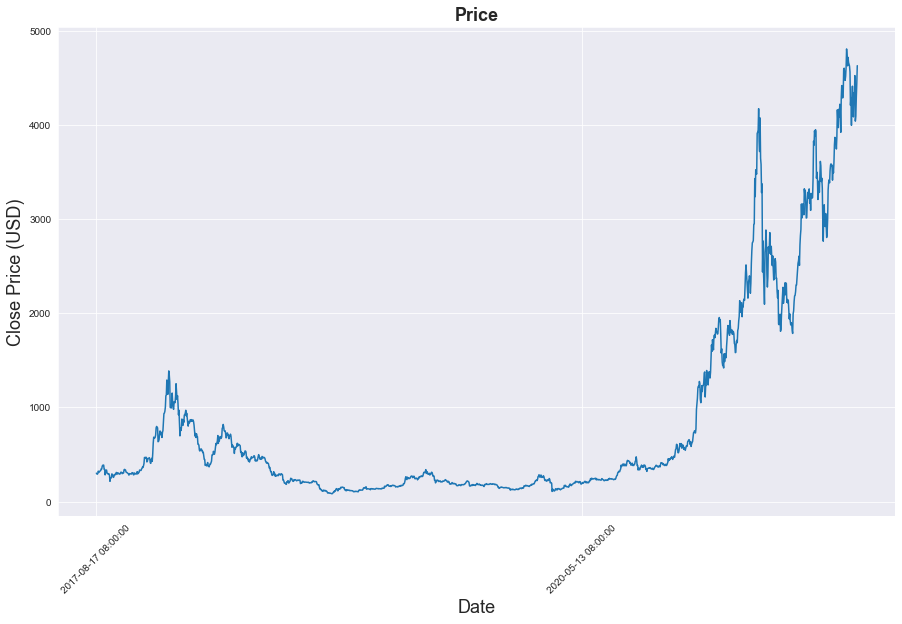

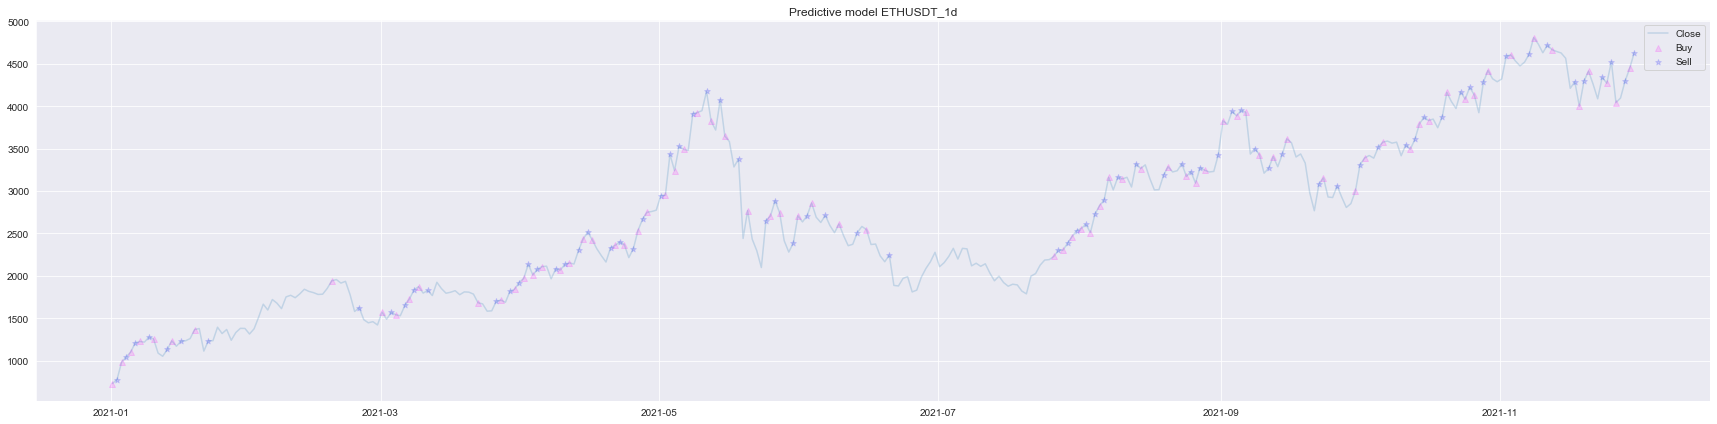

In [9]:
# ETHUSDT 1d
data_dir = "data/spot/monthly/klines/ETHUSDT/1d/2017-08-01_2021-12-01"
ticker = "ETHUSDT"
inter = "1d"

sell_rate = 0.015

main(ticker, inter, data_dir)

Total data: 9384
Training split: 7378
Test split: 2004
Num of Features: 18
Start training...
Epoch # 1
The loss calculated: 0.641947
Epoch # 2
The loss calculated: 0.605421
Epoch # 3
The loss calculated: 0.591178
Epoch # 4
The loss calculated: 0.583637
Epoch # 5
The loss calculated: 0.579218
Epoch # 6
The loss calculated: 0.575697
Epoch # 7
The loss calculated: 0.573274
Epoch # 8
The loss calculated: 0.571285
Epoch # 9
The loss calculated: 0.569754
Epoch # 10
The loss calculated: 0.568483
Epoch # 11
The loss calculated: 0.567503
Epoch # 12
The loss calculated: 0.566612
Epoch # 13
The loss calculated: 0.565786
Epoch # 14
The loss calculated: 0.565206
Epoch # 15
The loss calculated: 0.564587
Epoch # 16
The loss calculated: 0.564137
Epoch # 17
The loss calculated: 0.563733
Epoch # 18
The loss calculated: 0.563418
Epoch # 19
The loss calculated: 0.563072
Epoch # 20
The loss calculated: 0.562740
Epoch # 21
The loss calculated: 0.562391
Epoch # 22
The loss calculated: 0.562010
Epoch # 23
The

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2004/2004 [00:02<00:00, 893.87it/s]


ROI: 300.37
Initial Capital: 10000
Final Capital: 40037.24717784712
Numbers of trades: 226
The testing accuracy is 76.60 %


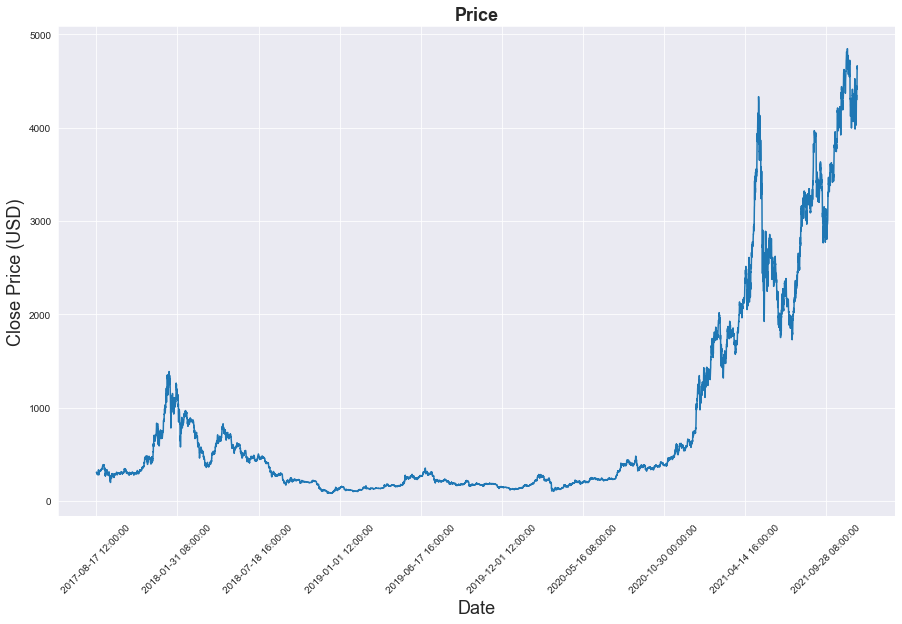

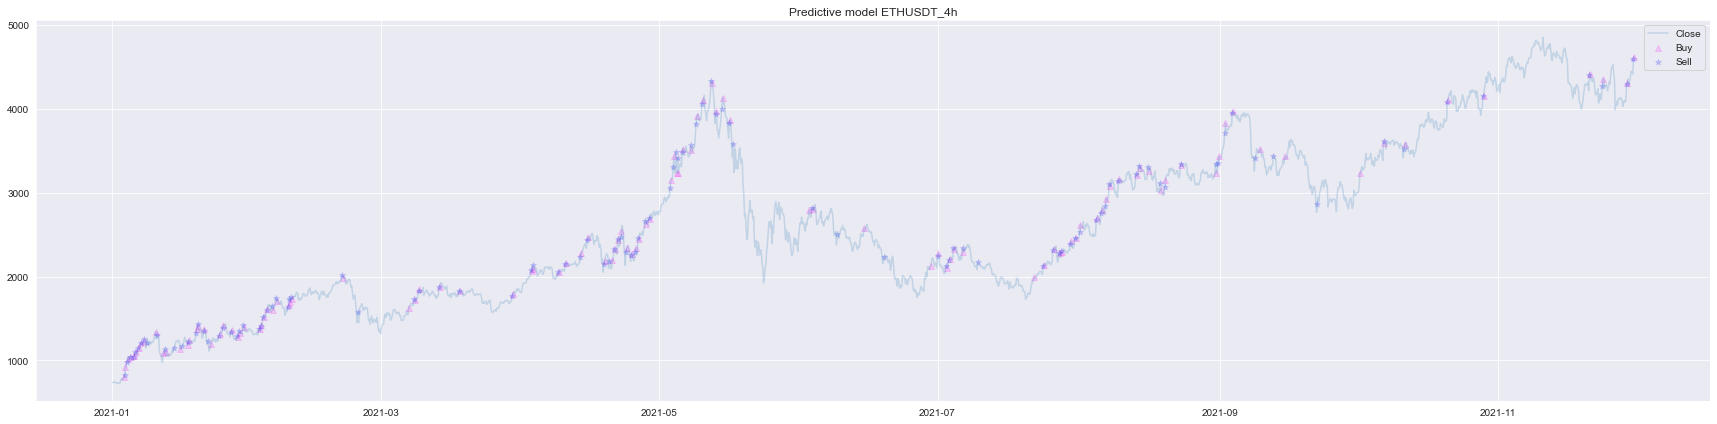

In [10]:
# ETHUSDT 4h
data_dir = "data/spot/monthly/klines/ETHUSDT/4h/2017-08-01_2021-12-01"
ticker = "ETHUSDT"
inter = "4h"
sell_rate = 0.03

main(ticker, inter, data_dir)

Total data: 37478
Training split: 29467
Test split: 8003
Num of Features: 18
Start training...
Epoch # 1
The loss calculated: 0.592902
Epoch # 2
The loss calculated: 0.583157
Epoch # 3
The loss calculated: 0.579530
Epoch # 4
The loss calculated: 0.577767
Epoch # 5
The loss calculated: 0.576341
Epoch # 6
The loss calculated: 0.575326
Epoch # 7
The loss calculated: 0.574702
Epoch # 8
The loss calculated: 0.574108
Epoch # 9
The loss calculated: 0.573739
Epoch # 10
The loss calculated: 0.573398
Epoch # 11
The loss calculated: 0.573111
Epoch # 12
The loss calculated: 0.572881
Epoch # 13
The loss calculated: 0.572688
Epoch # 14
The loss calculated: 0.572575
Epoch # 15
The loss calculated: 0.572441
Epoch # 16
The loss calculated: 0.572303
Epoch # 17
The loss calculated: 0.572172
Epoch # 18
The loss calculated: 0.571995
Epoch # 19
The loss calculated: 0.571847
Epoch # 20
The loss calculated: 0.571714
Epoch # 21
The loss calculated: 0.571592
Epoch # 22
The loss calculated: 0.571501
Epoch # 23
T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8003/8003 [00:08<00:00, 894.58it/s]


ROI: 393.66
Initial Capital: 10000
Final Capital: 49365.6641252135
Numbers of trades: 140
The testing accuracy is 73.09 %


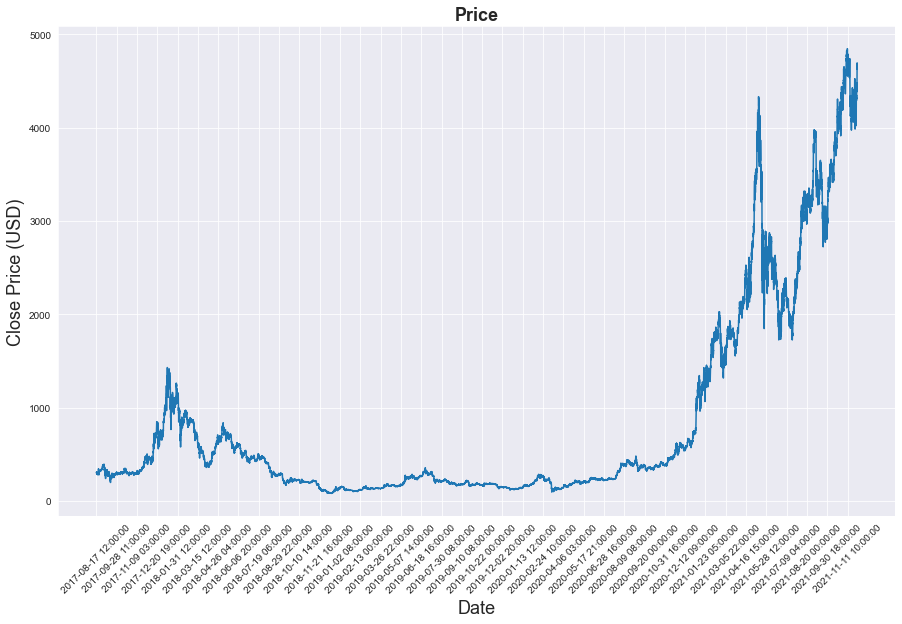

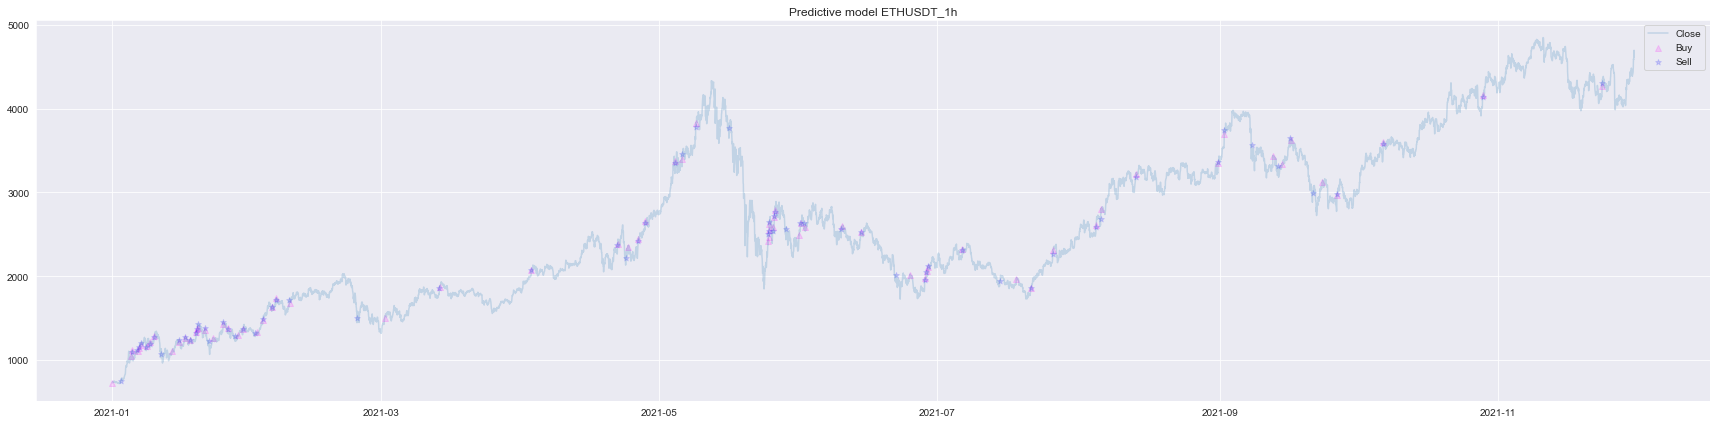

In [11]:
# ETHUSDT 1h
data_dir = "data/spot/monthly/klines/ETHUSDT/1h/2017-08-01_2021-12-01"
ticker = "ETHUSDT"
inter = "1h"
sell_rate = 0.03

main(ticker, inter, data_dir)

Total data: 1567
Training split: 1233
Test split: 334
Num of Features: 18
Start training...
Epoch # 1
The loss calculated: 0.699848
Epoch # 2
The loss calculated: 0.687037
Epoch # 3
The loss calculated: 0.677164
Epoch # 4
The loss calculated: 0.669358
Epoch # 5
The loss calculated: 0.663132
Epoch # 6
The loss calculated: 0.656403
Epoch # 7
The loss calculated: 0.649994
Epoch # 8
The loss calculated: 0.644311
Epoch # 9
The loss calculated: 0.639542
Epoch # 10
The loss calculated: 0.634719
Epoch # 11
The loss calculated: 0.632196
Epoch # 12
The loss calculated: 0.629565
Epoch # 13
The loss calculated: 0.627975
Epoch # 14
The loss calculated: 0.625665
Epoch # 15
The loss calculated: 0.623369
Epoch # 16
The loss calculated: 0.620941
Epoch # 17
The loss calculated: 0.619417
Epoch # 18
The loss calculated: 0.618203
Epoch # 19
The loss calculated: 0.616925
Epoch # 20
The loss calculated: 0.615453
Epoch # 21
The loss calculated: 0.614092
Epoch # 22
The loss calculated: 0.613163
Epoch # 23
The 

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 334/334 [00:00<00:00, 924.79it/s]


ROI: 30.08
Initial Capital: 10000
Final Capital: 13008.368804183787
Numbers of trades: 118
The testing accuracy is 63.17 %


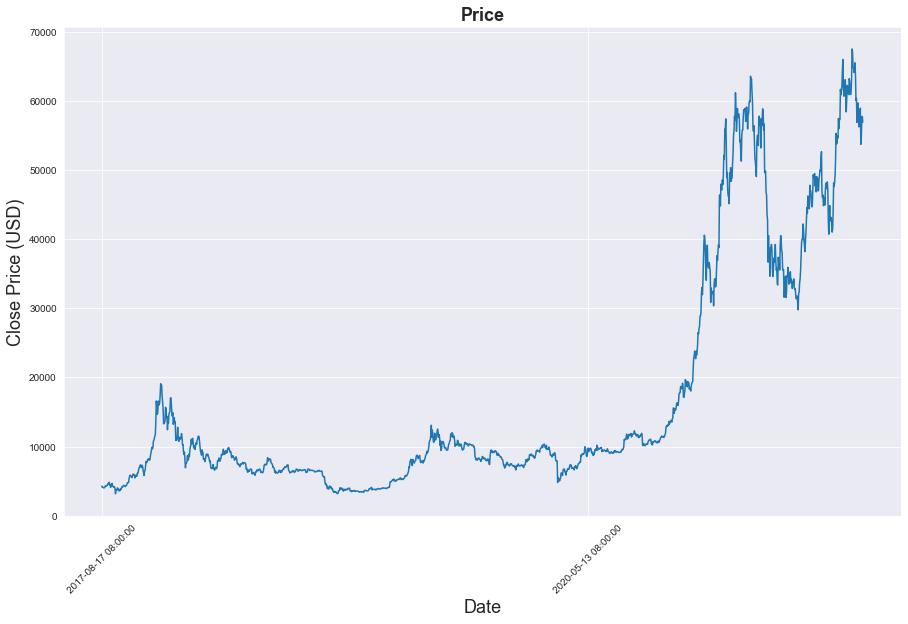

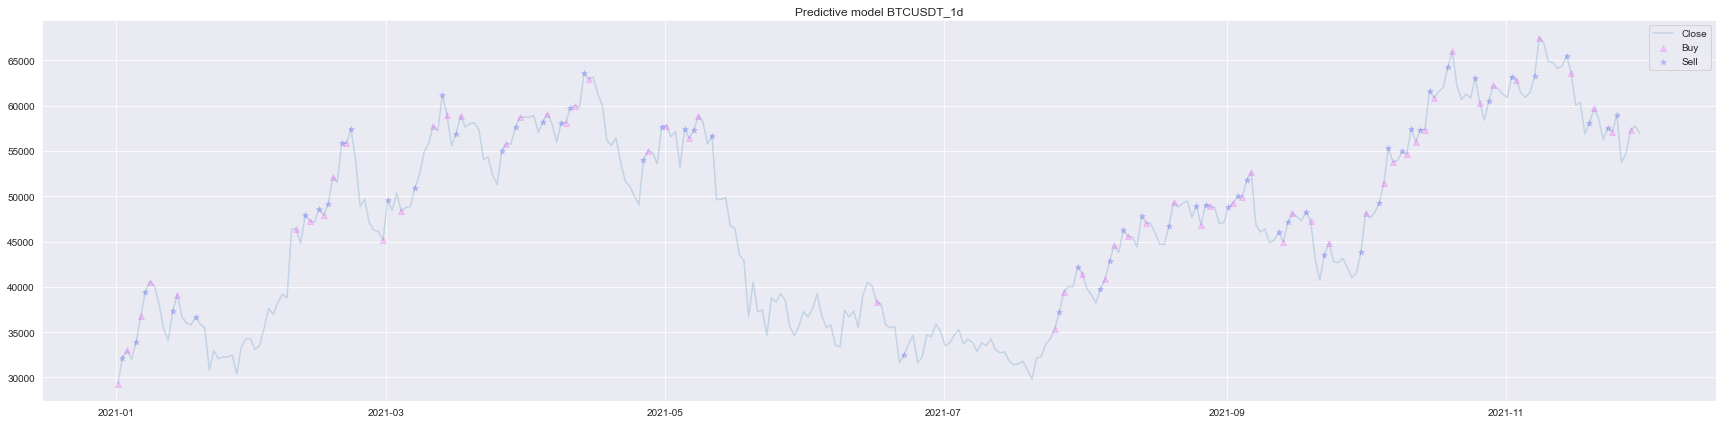

In [12]:
# BTCUSDT 1d
data_dir = "data/spot/monthly/klines/BTCUSDT/1d/2017-08-01_2021-12-01"
ticker = "BTCUSDT"
inter = "1d"
sell_rate = 0.015

main(ticker, inter, data_dir)

Total data: 9384
Training split: 7378
Test split: 2004
Num of Features: 18
Start training...
Epoch # 1
The loss calculated: 0.642634
Epoch # 2
The loss calculated: 0.607683
Epoch # 3
The loss calculated: 0.593470
Epoch # 4
The loss calculated: 0.586450
Epoch # 5
The loss calculated: 0.582023
Epoch # 6
The loss calculated: 0.578742
Epoch # 7
The loss calculated: 0.576276
Epoch # 8
The loss calculated: 0.574404
Epoch # 9
The loss calculated: 0.572781
Epoch # 10
The loss calculated: 0.571575
Epoch # 11
The loss calculated: 0.570425
Epoch # 12
The loss calculated: 0.569512
Epoch # 13
The loss calculated: 0.568751
Epoch # 14
The loss calculated: 0.568088
Epoch # 15
The loss calculated: 0.567571
Epoch # 16
The loss calculated: 0.567101
Epoch # 17
The loss calculated: 0.566666
Epoch # 18
The loss calculated: 0.566205
Epoch # 19
The loss calculated: 0.565810
Epoch # 20
The loss calculated: 0.565502
Epoch # 21
The loss calculated: 0.565269
Epoch # 22
The loss calculated: 0.564985
Epoch # 23
The

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2004/2004 [00:02<00:00, 888.84it/s]


ROI: 30.67
Initial Capital: 10000
Final Capital: 13066.91888842361
Numbers of trades: 111
The testing accuracy is 72.80 %


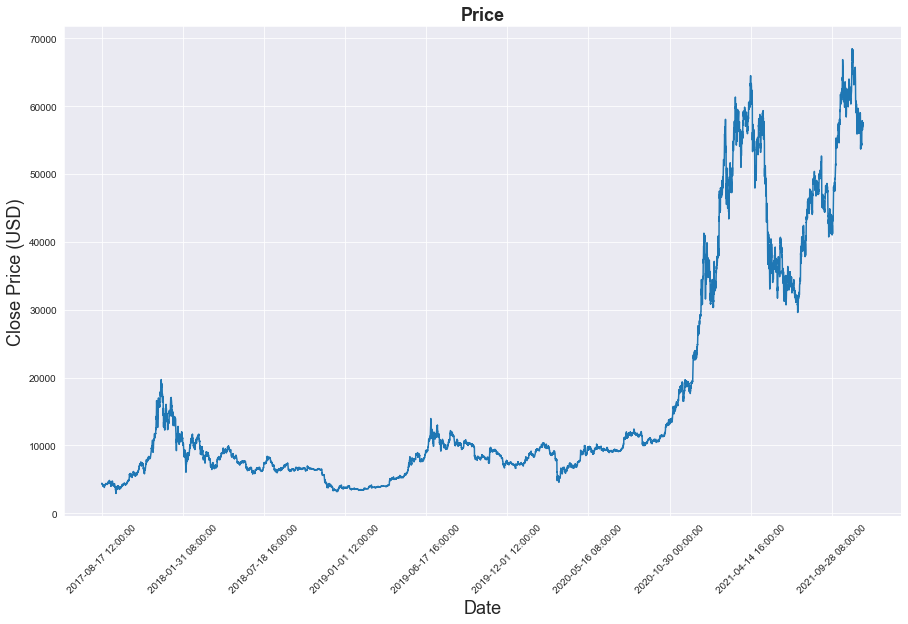

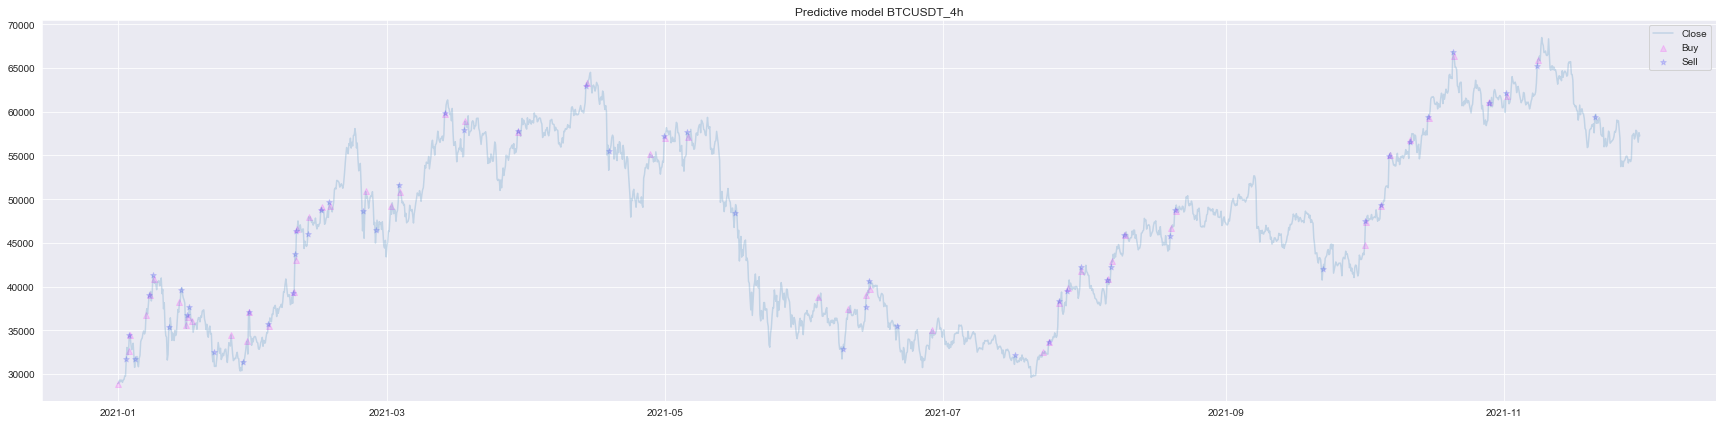

In [13]:
# BTCUSDT 4h
data_dir = "data/spot/monthly/klines/BTCUSDT/4h/2017-08-01_2021-12-01"
ticker = "BTCUSDT"
inter = "4h"
sell_rate = 0.03

main(ticker, inter, data_dir)

Total data: 37478
Training split: 29467
Test split: 8003
Num of Features: 18
Start training...
Epoch # 1
The loss calculated: 0.584729
Epoch # 2
The loss calculated: 0.573287
Epoch # 3
The loss calculated: 0.569053
Epoch # 4
The loss calculated: 0.567169
Epoch # 5
The loss calculated: 0.565691
Epoch # 6
The loss calculated: 0.564526
Epoch # 7
The loss calculated: 0.563883
Epoch # 8
The loss calculated: 0.563417
Epoch # 9
The loss calculated: 0.562945
Epoch # 10
The loss calculated: 0.562646
Epoch # 11
The loss calculated: 0.562273
Epoch # 12
The loss calculated: 0.561974
Epoch # 13
The loss calculated: 0.561759
Epoch # 14
The loss calculated: 0.561546
Epoch # 15
The loss calculated: 0.561310
Epoch # 16
The loss calculated: 0.561130
Epoch # 17
The loss calculated: 0.560972
Epoch # 18
The loss calculated: 0.560810
Epoch # 19
The loss calculated: 0.560670
Epoch # 20
The loss calculated: 0.560523
Epoch # 21
The loss calculated: 0.560408
Epoch # 22
The loss calculated: 0.560285
Epoch # 23
T

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8003/8003 [00:08<00:00, 904.08it/s]


ROI: 32.07
Initial Capital: 10000
Final Capital: 13207.174464080472
Numbers of trades: 64
The testing accuracy is 72.67 %


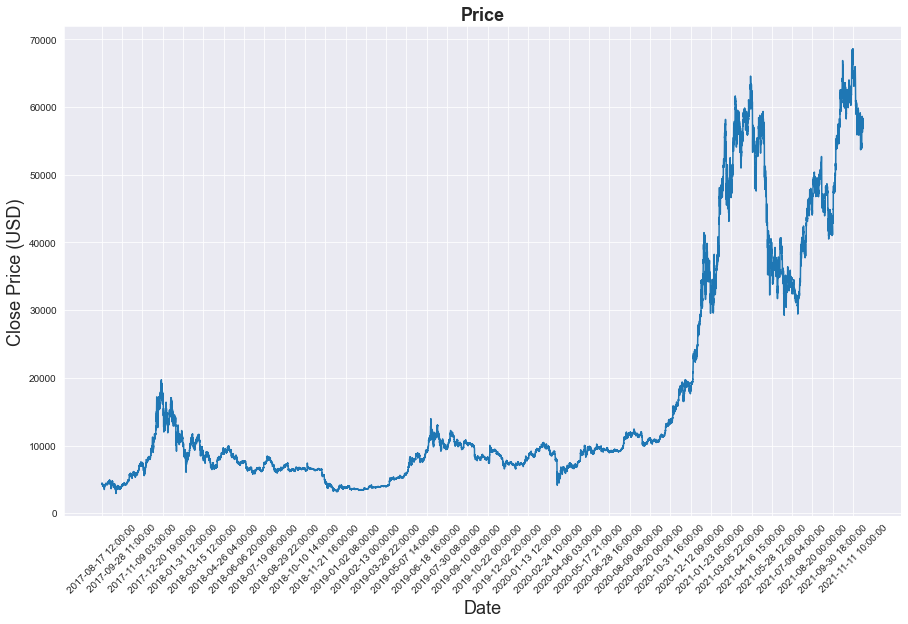

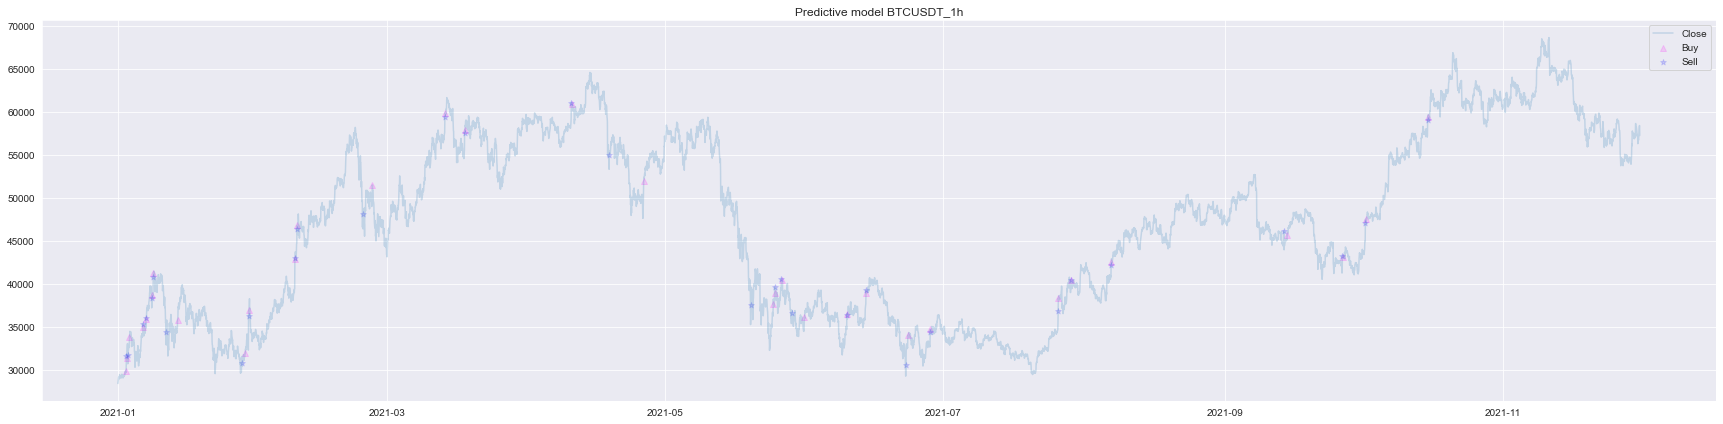

In [14]:
# BTCUSDT 1h
data_dir = "data/spot/monthly/klines/BTCUSDT/1h/2017-08-01_2021-12-01"
ticker = "BTCUSDT"
inter = "1h"
sell_rate = 0.03

main(ticker, inter, data_dir)